src: https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb

In [1]:
import requests
import json
import pandas as pd
import numpy as np

In [2]:
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [3]:
# response = requests.get("https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_COVID19/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json")
# print(response.status_code)

In [4]:
# data = response.json()
# flat = []

In [5]:
# for k, case in enumerate(data["features"]):
#        flat.append(data["features"][k]["attributes"])

In [6]:
# df = pd.read_json(json.dumps(flat))
# df.set_index("ObjectId", inplace = True)

In [7]:
# df.head()

In [8]:
# len(df)

In [9]:
# usecols=["Bundesland", "AnzahlFall", "Meldedatum"],

In [10]:
df = pd.read_csv("RKI_COVID19.csv",
                usecols=["Bundesland", "AnzahlFall", "NeuerFall", "Meldedatum"],
                parse_dates=["Meldedatum"])
df = df.rename(columns={"Meldedatum": "date", "Bundesland": "state"})
# df["date"] = df["date"].dt.strftime('%Y-%m-%d')
df["date"] = df["date"].dt.tz_localize(None)

In [11]:
df = df[df["NeuerFall"].isin([0, 1])]
df.drop("NeuerFall", axis = 1, inplace = True)

In [12]:
df.dtypes

state                 object
AnzahlFall             int64
date          datetime64[ns]
dtype: object

In [13]:
df = df.groupby(["state","date"]).sum()

In [14]:
df.sum()

AnzahlFall    148046
dtype: int64

In [15]:
states = df.squeeze()
states.head()

state              date      
Baden-Württemberg  2020-02-16    1
                   2020-02-23    3
                   2020-02-24    2
                   2020-02-25    2
                   2020-02-26    6
Name: AnzahlFall, dtype: int64

In [16]:
def prepare_cases(cases, cutoff=25):
    new_cases = cases

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

In [17]:
state_name = 'Bayern'
cases = states.xs(state_name).rename(f"{state_name} cases")

In [18]:
original, smoothed = prepare_cases(cases)

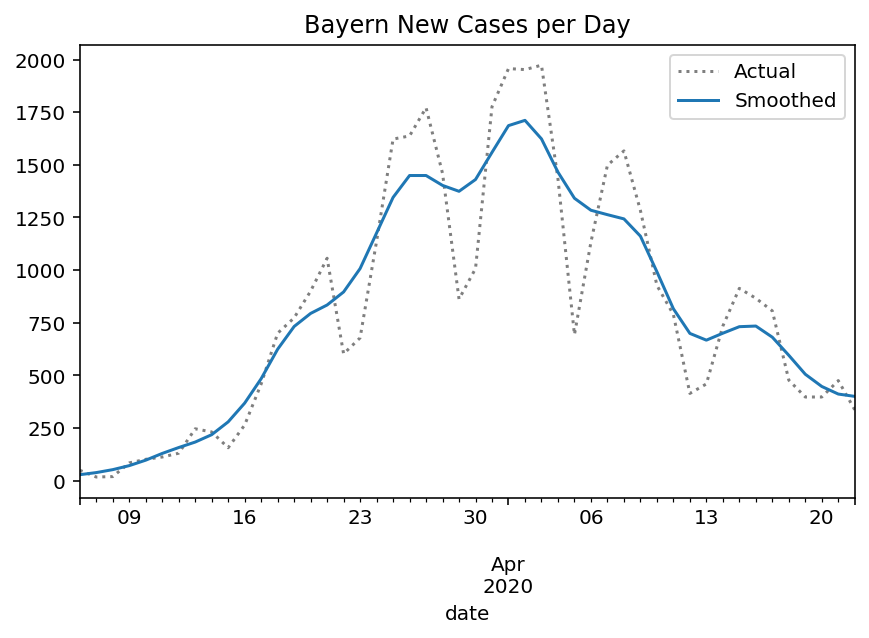

In [19]:
original.plot(title=f"{state_name} New Cases per Day",
              c='k',
              linestyle=':',
              alpha=.5,
              label='Actual',
              legend=True,
              figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

In [20]:
GAMMA = 1/7
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

In [21]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

In [22]:
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

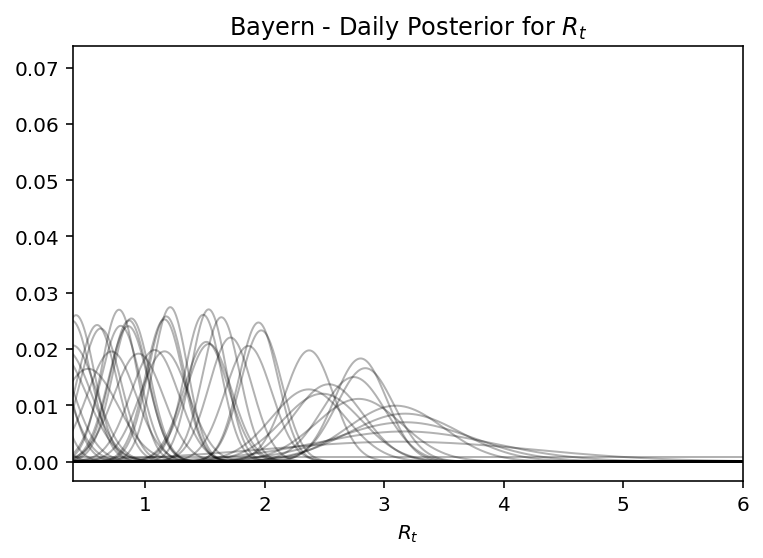

In [23]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

In [24]:
def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

In [25]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
date,,,
2020-04-18,0.34,0.00,0.62
2020-04-19,0.08,0.00,0.44
2020-04-20,0.15,0.00,0.49
2020-04-21,0.28,0.00,0.61
2020-04-22,0.53,0.11,0.89


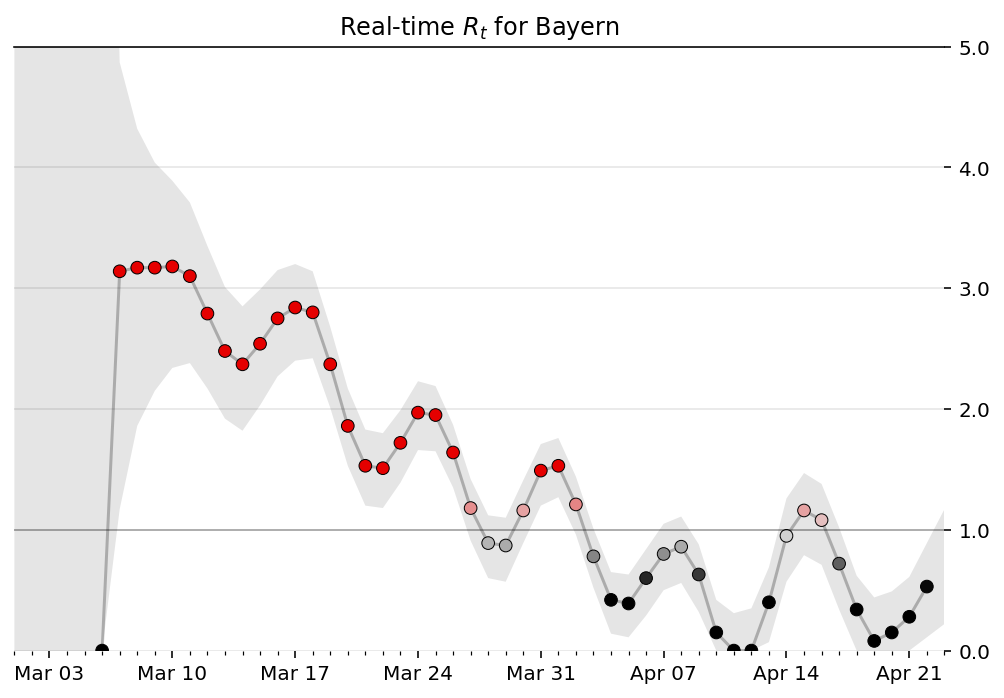

In [26]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [27]:
FILTERED_REGION_CODES = ["Bremen"]

In [28]:
sigmas = np.linspace(1/20, 1, 20)

targets = ~states.index.get_level_values('state').isin(FILTERED_REGION_CODES)
states_to_process = states.loc[targets]

results = {}

for state_name, cases in states_to_process.groupby(level='state'):
    
    print(state_name)
    new, smoothed = prepare_cases(cases, cutoff=25)
    
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(cases, cutoff=10)
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of state name
    results[state_name] = result
    clear_output(wait=True)

print('Done.')

Done.


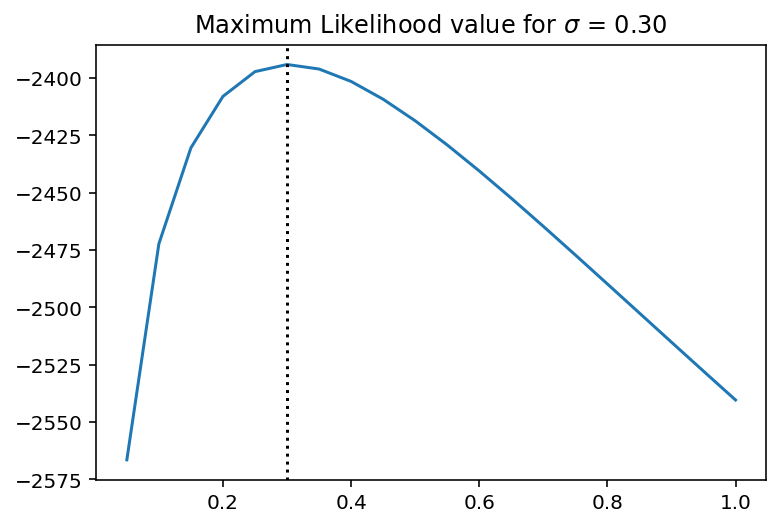

In [29]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

In [30]:
final_results = None

for state_name, result in results.items():
    print(state_name)
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
    clear_output(wait=True)

print('Done.')

Done.


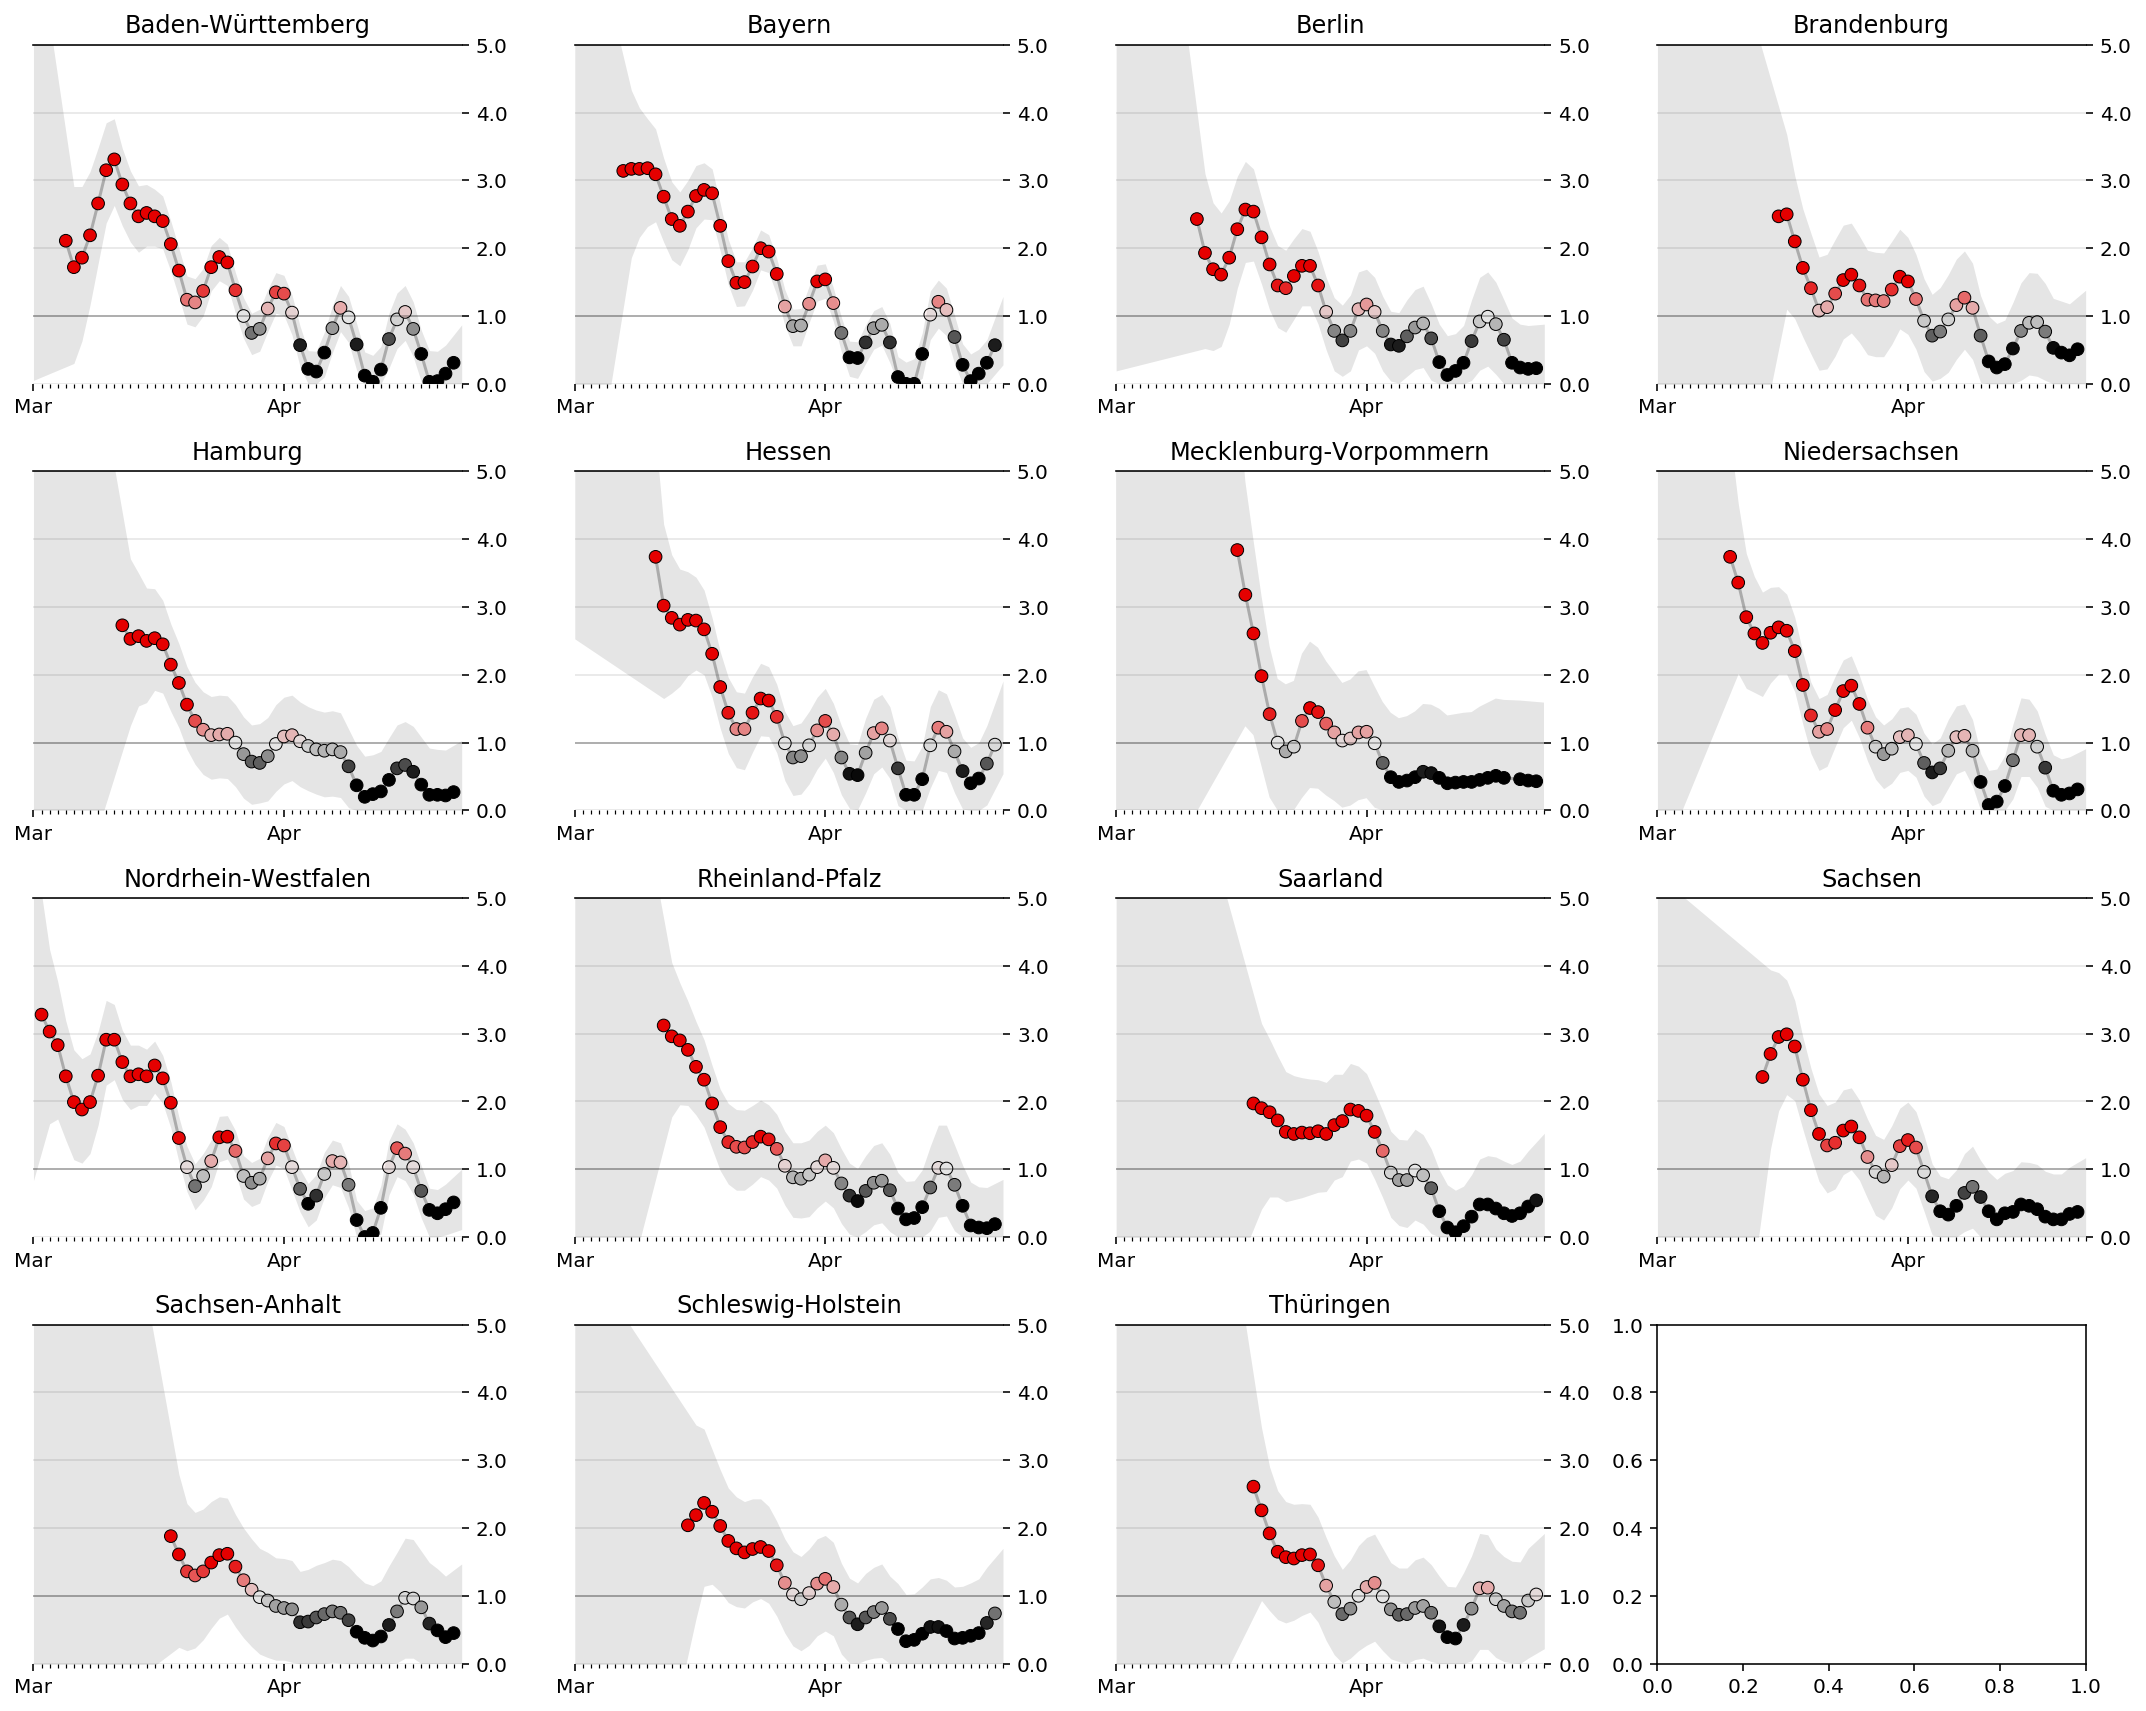

In [31]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(final_results.groupby('state')):
    plot_rt(result.iloc[1:], axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')

In [32]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

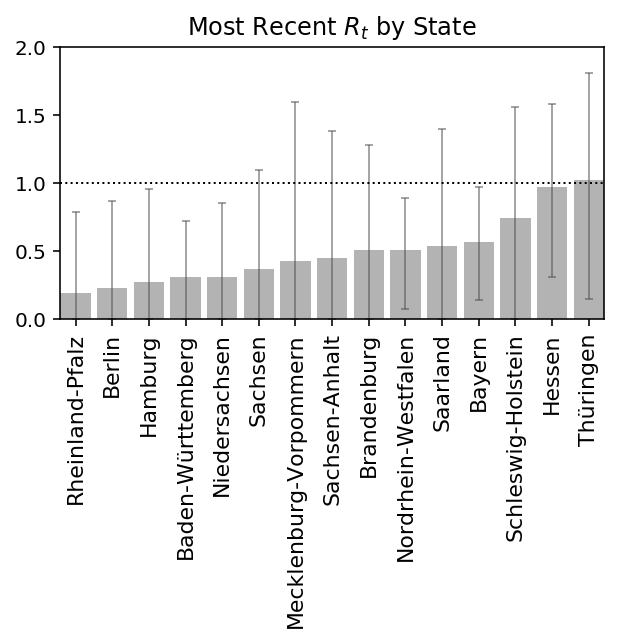

In [33]:
filtered = final_results.index.get_level_values(0).isin(FILTERED_REGION_CODES)
mr = final_results.loc[~filtered].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

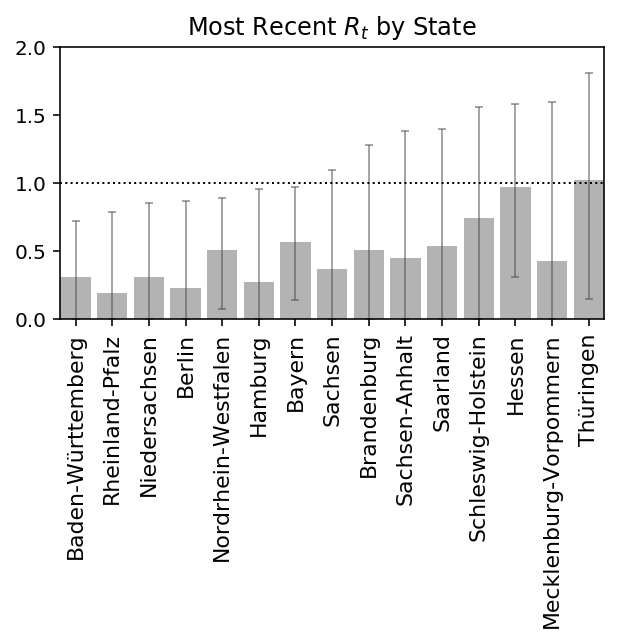

In [34]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

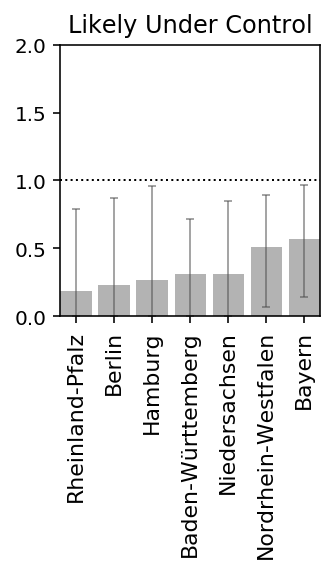

In [35]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

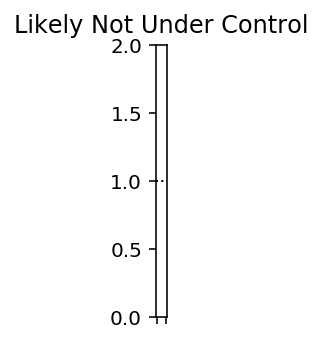

In [36]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');